# **Production Engineering**

# *Multiphase Flow*

***

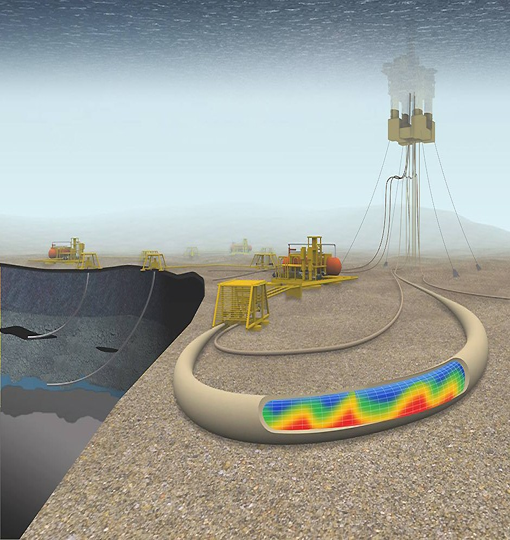

# Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
from math import sqrt, pi, log, sin, cos, radians, log10, e
from PIL import Image

In [2]:
%config Completer.use_jedi = False

# 1. Multiphase Flow Correlations

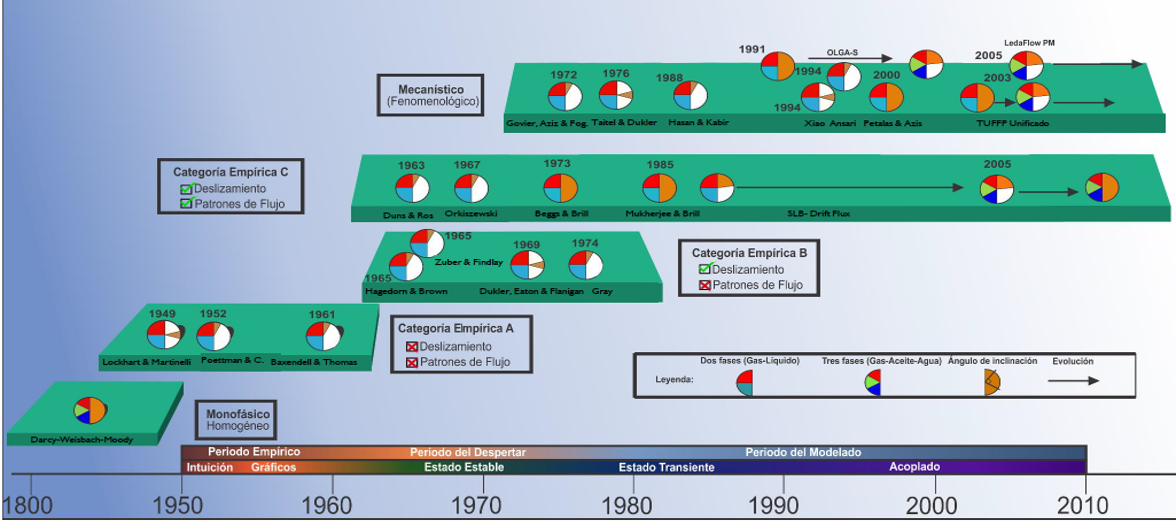

## 1.1. *Hagedorn & Brown Correlation*

In [21]:
def hagedorn_and_brown(qo, p, vsl, vsg, uo, ug, pho_o, pho_g,
                       d, sigma, epsi, l, theta) -> float:
    # Mix velocity
    vm = vsl + vsg
    # Cross sectional area
    A = ((pi / 4) * d**2) / 144
    # Fluids flow rates
    ql = vsl * A
    qg = vsg * A
    # Determine flow regime
    Lb = 1.071 - 0.2218 * (vm**2 / (6/12))
    if Lb < 0.13:
        Lb = 0.13
    holdup_g = qg / (ql + qg)
    if holdup_g > Lb:
        print('The Hagedorn & Brown correlation can be used')
    else:
        print('The Griffith must be used')
    holdup_l = 1 - holdup_g
    # Non holdup mix density
    pho_n = pho_o * holdup_l + pho_g * (1 - holdup_g)
    # Calculate the 4 four dimensionless numbers
    Nvl = 1.938 * vsl * (pho_o / sigma)**0.25
    Nvg = 1.938 * vsg * (pho_o / sigma)**0.25
    Nd = 120.872 * (d / 12) * (pho_o / sigma)**0.5
    Nl = 0.15726 * uo * (1 / (pho_o * sigma**3))**0.25
    # Process to calculate the Liquid Holdup
    fig1 = Image.open('img1.png')
    fig1.show()
    CNl = float(input(f'Enter the value of CNL, if NL is {Nl} ->'))
    cons1 = (Nvl* p**0.1 * CNl) / (Nvg**0.575 * p**0.1 * Nd)
    fig2 = Image.open('img2.png')
    fig2.show()
    Hl_psi = float(input(f'Enter the value of HL/psi, if cons1 is {cons1} ->'))
    cons2 = (Nvg* Nl**0.380) / Nd**2.14
    fig3 = Image.open('img3.png')
    fig3.show()
    psi = float(input(f'Enter the value of psi, if cons2 is {cons2} ->'))
    # Liquid Holdup
    Hl = psi * Hl_psi
    # Mix density
    pho_m = pho_o * Hl + pho_g * (1 - Hl)
    # Mix viscosity
    um = uo**Hl * ug**(1 - Hl)
    # Reynolds Number
    Nre_m = (1488 * pho_n* vm * (d/12)) / um
    # Friction factor
    f = (1 / (1.14 - 2 * log10((epsi / (d / 12)) + (21.25 / Nre_m**0.9))))**2
    pho_f = pho_n**2 / pho_m
    # Pressure gradient due to potential energy
    grad_pe = ((32.17 / 32.17) * (pho_m * cos(theta))) / 144
    # Pressure gradiente due to friction
    grad_f = ((2 * f * pho_f * vm**2) / (32.17 * (d / 12))) / 144
    dp_total = round((grad_pe + grad_f) * l, 2)
    return dp_total

## *Ejercicio 1*

In [22]:
# Data
qo = 1000 #bpd
p = 1700 #psi
vsl = 3.97 #ft/s
vsg = 3.86 #ft/s
uo = 0.97 #cp
ug = 0.016 #cp
pho_o = 47.61 #lb/ft3
pho_g = 5.88 #lb/ft3
sigma = 8.41 #dynes/cm
d = 6 #inch
epsi = 0.0006 #ft
l = 10000 #ft
theta = 0

In [25]:
dp = hagedorn_and_brown(qo, p, vsl, vsg, uo, ug, pho_o, pho_g, d, sigma, epsi, l, theta)
print(f' the total pressure drop is: {dp} psia')

The Hagedorn & Brown correlation can be used


Enter the value of CNL, if NL is 0.011758947824811093 -> 0.0019
Enter the value of HL/psi, if cons1 is 3.842649852815359e-05 -> 0.3
Enter the value of psi, if cons2 is 5.1443259293651493e-05 -> 1


 the total pressure drop is: 1714.8 psia


## 1.2. *Beggs & Brills Correlation*

In [6]:
def beggs_and_brills(qo, uo, ug, pho_0, pho_g, d, sigma, epsi, l, theta, qg=None, gor=None):
    A = (pi * (d / 2)**2) / 144
    Vsl = (qo * 5.615) / (A * 86400)
    if qg is not None and gor is None:
        Vsg = qg / (A * 86400)
    else:
        Vsg = Vsl * gor
    Vm = Vsl + Vsg
    holdup_l = Vsl / Vm
    Nfr = Vm**2 / (32.2 * (d/12))
    L1 = 316 * holdup_l**0.302
    L2 = 0.0009252 * holdup_l**-2.4684
    L3 = 0.10 * holdup_l**(-1.4516)
    L4 = 0.51 * holdup_l**-6.738
    if ((0.001 <= holdup_l < 0.4) and (L3 < Nfr < L1)) or (holdup_l >= 0.001 and Nfr <= L2):
        print('The flow regime is intermitent')
        Hlo = (0.845 * holdup_l**0.5351) / Nfr**0.0173
        Nvl = 1.938 * Vsl * (pho_0 / sigma)**0.25
        C = (1 - holdup_l) * \
        log(2.96 * holdup_l**0.305 * Nvl**-0.4473 * Nfr**0.0978)
        cons = 1 + C * (sin(radians(1.8*theta)) - 0.333 * sin(radians(1.8*theta))**3)
        Hl = cons * Hlo
    elif (holdup_l < 0.01 and Nfr < L1) or (holdup_l >= 0.01 and Nfr <= L2):
        print('The flow regime is segregated')
        Hlo = (0.98 * holdup_l**0.4846) / Nfr**0.0868
        Nvl = 1.938 * Vsl * (pho_0 / sigma)**0.25
        C = (1 - holdup_l) * \
        log(0.011 * holdup_l**-3.5868 * Nvl**3.519 * Nfr**-1.614)
        cons = 1 + C * (sin(radians(1.8*theta)) - 0.333 * sin(radians(1.8*theta))**3)
        Hl = cons * Hlo
    elif (holdup_l < 0.04 and Nfr >= L1) or (holdup_l >= 0.4 and Nfr > L4):
        print('The flow regime is Distributed')
        Hlo = (1.065 * holdup_l**0.5824) / Nfr**0.0609
        C = 0
        cons = 1
        Hl = cons * Hlo
    elif (holdup_l >= 0.01) and (L2 < Nfr <= L3):
        print('The flow regime is Transition')
        A = (L3 - Nfr) / (L3 - L2)
        B = 1 - A
        Hlo_seg = (0.98 * holdup_l ** 0.4846) / Nfr ** 0.0868
        Hlo_inter = (0.845 * holdup_l ** 0.5351) / Nfr ** 0.0173
        Nvl = 1.938 * Vsl * (pho_0 / sigma) ** 0.25
        C_seg = (1 - holdup_l) * \
            log(0.011 * holdup_l ** -3.5868 * Nvl ** 3.519 * Nfr ** -1.614)
        C_inter = (1 - holdup_l) * \
            log(2.96 * holdup_l ** 0.305 * Nvl ** -0.4473 * Nfr ** 0.0978)
        cons_seg = 1 + C_seg * (sin(radians(1.8 * theta)) - 0.333 * sin(radians(1.8 * theta)) ** 3)
        cons_inter = 1 + C_inter * (sin(radians(1.8 * theta)) - 0.333 * sin(radians(1.8 * theta)) ** 3)
        Hl_seg = cons_seg * Hlo_seg
        Hl_inter = cons_inter * Hlo_inter
        Hl = A * Hl_seg + B * Hl_inter
    pho_m = pho_0 * Hl + pho_g * (1 - Hl)
    grad_pe = ((32.2 / 32.2) * pho_m * (sin(radians(theta)))) / 144
    pho_n = pho_0 * holdup_l + pho_g * (1 - holdup_l)
    u_n = uo * holdup_l + ug * (1 - holdup_l)
    Nre_m = (1488 * pho_n * Vm * (d / 12)) / u_n
    f = (1 / (1.14 - 2 * log10((epsi / (d / 12)) + (21.25 / Nre_m**0.9))))**2
    x = holdup_l / (Hl**2)
    s = log(x) / (-0.0523 + 3.182 * log(x) - 0.08725 * \
                      (log(x))**2 + 0.01853 * (log(x))**4)
    ftp = f * e**s
    grad_f = (2 * ftp * pho_n * Vm**2) / (32.2 * (d / 12) * 144)
    grad_total = round(grad_pe + grad_f, 4)
    dp_total = round(grad_total * l, 3)
    return grad_total, dp_total

## *Ejercicio 2*

In [7]:
angles = [0, 15, 30, 90]
for angle in angles:
    dp_total = beggs_and_brills(2000, 16, 0.02, 49.9, 2.84, 3, 30, 0.0006, 10300,\
                                angle, gor=1.5434)[1]
    print(f"dp total at {angle} degrees: {dp_total} psia")

The flow regime is intermitent
dp total at 0 degrees: 861.08 psia
The flow regime is intermitent
dp total at 15 degrees: 1368.87 psia
The flow regime is intermitent
dp total at 30 degrees: 1861.21 psia
The flow regime is intermitent
dp total at 90 degrees: 2795.42 psia
